# RNN

Using device: cuda


Epoch 1: 100%|██████████| 11069/11069 [00:13<00:00, 841.66it/s]


Epoch 1, Loss: 0.3033


Epoch 2: 100%|██████████| 11069/11069 [00:13<00:00, 849.49it/s]


Epoch 2, Loss: 0.2524


Epoch 3: 100%|██████████| 11069/11069 [00:13<00:00, 850.92it/s]


Epoch 3, Loss: 0.2427


Epoch 4: 100%|██████████| 11069/11069 [00:12<00:00, 852.78it/s]


Epoch 4, Loss: 0.2361


Epoch 5: 100%|██████████| 11069/11069 [00:12<00:00, 853.14it/s]


Epoch 5, Loss: 0.2317


Epoch 6: 100%|██████████| 11069/11069 [00:12<00:00, 851.66it/s]


Epoch 6, Loss: 0.2280


Epoch 7: 100%|██████████| 11069/11069 [00:12<00:00, 853.09it/s]


Epoch 7, Loss: 0.2253


Epoch 8: 100%|██████████| 11069/11069 [00:12<00:00, 852.36it/s]


Epoch 8, Loss: 0.2232


Epoch 9: 100%|██████████| 11069/11069 [00:12<00:00, 851.98it/s]


Epoch 9, Loss: 0.2213


Epoch 10: 100%|██████████| 11069/11069 [00:12<00:00, 874.29it/s]


Epoch 10, Loss: 0.2201

====== Evaluation Metrics ======
Accuracy: 0.9414
Recall: 0.2866
Precision: 0.2916
F1 Score: 0.2891
ROC AUC: 0.7942

Confusion Matrix:
                Predicted 0  Predicted 1
Actual 0 (TN)        658467         20499
Actual 1 (TP)         21005          8439


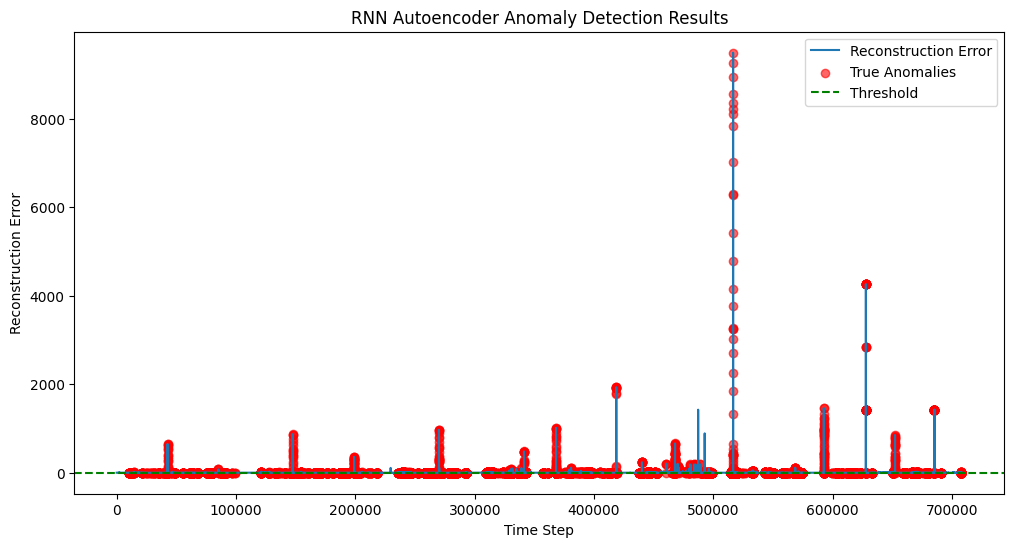


Results saved with recall metrics!


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                           precision_recall_fscore_support, confusion_matrix,
                           recall_score)
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_data = np.load('/home/haoqian/anomaly/SMD/SMD_train.npy')
test_data = np.load('/home/haoqian/anomaly/SMD/SMD_test.npy')
test_label = np.load('/home/haoqian/anomaly/SMD/SMD_test_label.npy')

def preprocess(data, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    df = pd.DataFrame(data)
    return df.ffill().bfill().values, scaler

train_data, scaler = preprocess(train_data)
test_data, _ = preprocess(test_data, scaler)

window_size = 10
def create_sequences(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data)-window_size)])

X_train = create_sequences(train_data, window_size)
X_test = create_sequences(test_data, window_size)
y_test = test_label[window_size:]


class RNNAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.encoder = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.decoder = nn.RNN(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        # Encoder
        _, hidden = self.encoder(x)
        # Decoder
        output, _ = self.decoder(
            torch.zeros(x.size(0), x.size(1), hidden.size(2)).to(x.device),
            hidden
        )
        return self.fc(output)

model = RNNAutoencoder(X_train.shape[2]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

batch_size = 64
train_dataset = TensorDataset(
    torch.FloatTensor(X_train).to(device),
    torch.FloatTensor(X_train).to(device)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def train(model, loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in tqdm(loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            del output, loss
            torch.cuda.empty_cache()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

train(model, train_loader)

def predict_in_batches(model, data, batch_size=64):
    model.eval()
    scores = []
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = torch.FloatTensor(data[i:i+batch_size]).to(device)
            recon = model(batch)
            mse = torch.mean((batch - recon)**2, dim=(1, 2))
            scores.extend(mse.cpu().numpy())
            del batch, recon, mse
            torch.cuda.empty_cache()
    return np.array(scores)

train_scores = predict_in_batches(model, X_train)
test_scores = predict_in_batches(model, X_test)

threshold = np.quantile(train_scores, 0.99)
test_preds = (test_scores > threshold).astype(int)

def full_evaluation(true, pred, scores):
    print("\n====== Evaluation Metrics ======")
    print(f"Accuracy: {accuracy_score(true, pred):.4f}")
    print(f"Recall: {recall_score(true, pred):.4f}")  
    print(f"Precision: {precision_recall_fscore_support(true, pred, average='binary')[0]:.4f}")
    print(f"F1 Score: {f1_score(true, pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(true, scores):.4f}")
    
    # 混淆矩阵（添加标签说明）
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    print("\nConfusion Matrix:")
    print(f"                Predicted 0  Predicted 1")
    print(f"Actual 0 (TN)    {tn:>10}    {fp:>10}")
    print(f"Actual 1 (TP)    {fn:>10}    {tp:>10}")
    
    # 可视化
    plt.figure(figsize=(12, 6))
    plt.plot(scores, label='Reconstruction Error')
    plt.scatter(np.where(true == 1)[0], scores[true == 1], 
                color='red', label='True Anomalies', alpha=0.6)
    plt.axhline(threshold, color='green', linestyle='--', label='Threshold')
    plt.title("RNN Autoencoder Anomaly Detection Results")
    plt.xlabel("Time Step")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.show()

full_evaluation(y_test, test_preds, test_scores)

results = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': test_preds,
    'anomaly_score': test_scores
})
results.to_csv('smd_rnn_results.csv', index=False)
print("\nResults saved with recall metrics!")
29.16,28.66,28.91,79.42,94.14

Using device: cuda


Epoch 1: 100%|██████████| 11069/11069 [00:21<00:00, 522.00it/s]


Epoch 1, Loss: 0.3772


Epoch 2: 100%|██████████| 11069/11069 [00:20<00:00, 530.44it/s]


Epoch 2, Loss: 0.3183


Epoch 3: 100%|██████████| 11069/11069 [00:21<00:00, 507.48it/s]


Epoch 3, Loss: 0.3101


Epoch 4: 100%|██████████| 11069/11069 [00:21<00:00, 507.29it/s]


Epoch 4, Loss: 0.3053


Epoch 5: 100%|██████████| 11069/11069 [00:21<00:00, 503.52it/s]


Epoch 5, Loss: 0.3008


Epoch 6: 100%|██████████| 11069/11069 [00:21<00:00, 503.30it/s]


Epoch 6, Loss: 0.2973


Epoch 7: 100%|██████████| 11069/11069 [00:21<00:00, 503.25it/s]


Epoch 7, Loss: 0.2949


Epoch 8: 100%|██████████| 11069/11069 [00:21<00:00, 506.72it/s]


Epoch 8, Loss: 0.2920


Epoch 9: 100%|██████████| 11069/11069 [00:21<00:00, 506.79it/s]


Epoch 9, Loss: 0.2902


Epoch 10: 100%|██████████| 11069/11069 [00:21<00:00, 506.15it/s]


Epoch 10, Loss: 0.2882


Epoch 11: 100%|██████████| 11069/11069 [00:21<00:00, 505.53it/s]


Epoch 11, Loss: 0.2866


Epoch 12: 100%|██████████| 11069/11069 [00:21<00:00, 503.24it/s]


Epoch 12, Loss: 0.2854


Epoch 13: 100%|██████████| 11069/11069 [00:22<00:00, 502.67it/s]


Epoch 13, Loss: 0.2845


Epoch 14: 100%|██████████| 11069/11069 [00:21<00:00, 506.39it/s]


Epoch 14, Loss: 0.2834


Epoch 15: 100%|██████████| 11069/11069 [00:21<00:00, 508.40it/s]


Epoch 15, Loss: 0.2826

====== Evaluation Metrics ======
Accuracy: 0.9356
Recall: 0.3282
Precision: 0.2723
F1 Score: 0.2976
ROC AUC: 0.8307

Confusion Matrix:
                Predicted 0  Predicted 1
Actual 0 (TN)        653136         25830
Actual 1 (TP)         19780          9664


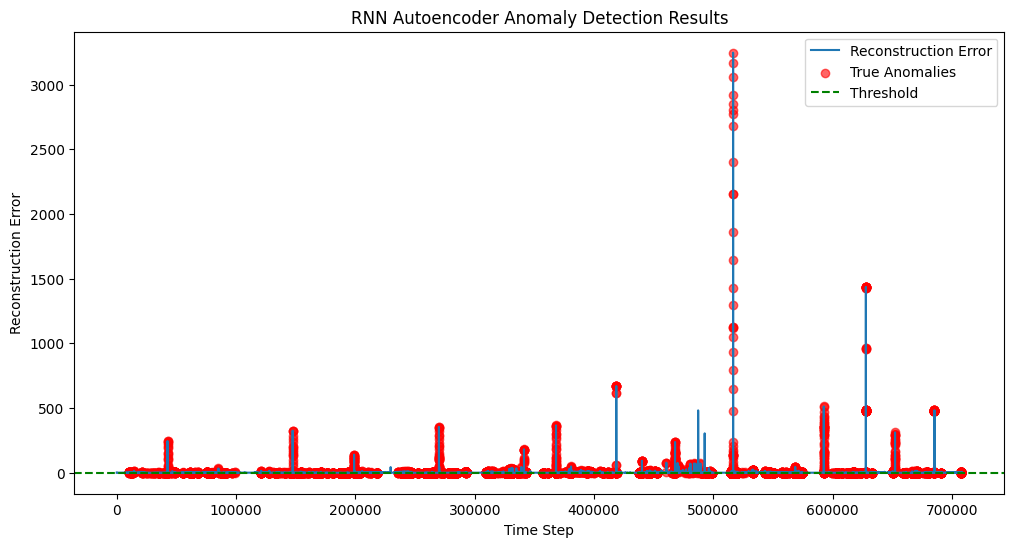

Model parameters saved to /home/haoqian/anomaly/ensamble-learning/models/rnn_autoencoder.pth


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                           precision_recall_fscore_support, confusion_matrix,
                           recall_score)  
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


train_data = np.load('/home/haoqian/anomaly/ml/fusion/fusion_train.npy')
test_data = np.load('/home/haoqian/anomaly/ml/fusion/fusion_test.npy')
test_label = np.load('/home/haoqian/anomaly/SMD/SMD_test_label.npy')

def preprocess(data, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    df = pd.DataFrame(data)
    return df.ffill().bfill().values, scaler

train_data, scaler = preprocess(train_data)
test_data, _ = preprocess(test_data, scaler)

window_size = 10
def create_sequences(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data)-window_size)])

X_train = create_sequences(train_data, window_size)
X_test = create_sequences(test_data, window_size)
y_test = test_label[window_size:]

class RNNAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super().__init__()
        self.encoder = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.decoder = nn.RNN(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        # Encoder
        _, hidden = self.encoder(x)
        # Decoder
        output, _ = self.decoder(
            torch.zeros(x.size(0), x.size(1), hidden.size(2)).to(x.device),
            hidden
        )
        return self.fc(output)

model = RNNAutoencoder(X_train.shape[2]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

batch_size = 64
train_dataset = TensorDataset(
    torch.FloatTensor(X_train).to(device),
    torch.FloatTensor(X_train).to(device)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

def train(model, loader, epochs=15):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_x, batch_y in tqdm(loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            del output, loss
            torch.cuda.empty_cache()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

train(model, train_loader)

def predict_in_batches(model, data, batch_size=64):
    model.eval()
    scores = []
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = torch.FloatTensor(data[i:i+batch_size]).to(device)
            recon = model(batch)
            mse = torch.mean((batch - recon)**2, dim=(1, 2))
            scores.extend(mse.cpu().numpy())
            
            del batch, recon, mse
            torch.cuda.empty_cache()
    return np.array(scores)

train_scores = predict_in_batches(model, X_train)
test_scores = predict_in_batches(model, X_test)

threshold = np.quantile(train_scores, 0.99)
test_preds = (test_scores > threshold).astype(int)

def full_evaluation(true, pred, scores):
    print("\n====== Evaluation Metrics ======")
    print(f"Accuracy: {accuracy_score(true, pred):.4f}")
    print(f"Recall: {recall_score(true, pred):.4f}")  # 新增Recall显示
    print(f"Precision: {precision_recall_fscore_support(true, pred, average='binary')[0]:.4f}")
    print(f"F1 Score: {f1_score(true, pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(true, scores):.4f}")

    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    print("\nConfusion Matrix:")
    print(f"                Predicted 0  Predicted 1")
    print(f"Actual 0 (TN)    {tn:>10}    {fp:>10}")
    print(f"Actual 1 (TP)    {fn:>10}    {tp:>10}")

    plt.figure(figsize=(12, 6))
    plt.plot(scores, label='Reconstruction Error')
    plt.scatter(np.where(true == 1)[0], scores[true == 1], 
                color='red', label='True Anomalies', alpha=0.6)
    plt.axhline(threshold, color='green', linestyle='--', label='Threshold')
    plt.title("RNN Autoencoder Anomaly Detection Results")
    plt.xlabel("Time Step")
    plt.ylabel("Reconstruction Error")
    plt.legend()
    plt.show()

full_evaluation(y_test, test_preds, test_scores)

# Save the model parameters
model_path = '/home/haoqian/anomaly/ensamble-learning/models/rnn_autoencoder.pth'
torch.save(model.state_dict(), model_path)
print(f"Model parameters saved to {model_path}")


In [ ]:
np.save("/home/haoqian/anomaly/ensamble-learning/models/train_scores_rnn.npy",train_scores)

In [ ]:
# Load model parameters for testing
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
train_data = np.load('/home/haoqian/anomaly/ml/fusion/fusion_train.npy')
test_data = np.load('/home/haoqian/anomaly/ml/fusion/fusion_test.npy')
test_label = np.load('/home/haoqian/anomaly/SMD/SMD_test_label.npy')
def preprocess(data, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    df = pd.DataFrame(data)
    return df.ffill().bfill().values, scaler
train_data, scaler = preprocess(train_data)
test_data, _ = preprocess(test_data, scaler)
window_size = 10
def create_sequences(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data)-window_size)])
X_train = create_sequences(train_data, window_size)
X_test = create_sequences(test_data, window_size)
y_test = test_label[window_size:]

def load_model(input_size, model_path):
    model = RNNAutoencoder(input_size).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model
model = load_model(X_train.shape[2], model_path)
test_scores = predict_in_batches(model, X_test)